In [288]:
import pandas as pd, geopandas as gpd
from shapely.geometry import Point
import cenpy as cen
import pysal
import us


#census_key

In [17]:
#view all of the available Census APIs
datasets = list(cen.explorer.available(verbose=True).items())
datasets_df= pd.DataFrame(datasets,columns=('id','description'))
datasets_df.head()


,id,description
0,NONEMP2007,2007 Nonemployer Statistics: Non Employer Stat...
1,POPESTagesex,Vintage 2014 Population Estimates: National An...
2,ZBPTotal2011,2011 County Business Patterns - Zip Code Busin...
3,ITMONTHLYIMPORTSUSDA,Time Series International Trade: Monthly U.S. ...
4,POPESTnatmonthly2015,Vintage 2015 Population Estimates: National Mo...


In [82]:
ACS_5yr_2017_code ='ACSDT5Y2017'
datasets_df[datasets_df['id'].str.contains('ACS') & datasets_df['id'].str.contains('2017') ]

,id,description
34,ACSDP5Y2017,ACS 5-Year Data Profiles
37,ACSCP5Y2017,ACS 5-Year Comparison Profiles
39,ACSDP1Y2017,ACS 1-Year Data Profiles
96,ACSCP1Y2017,ACS 1-Year Comparison Profiles
130,ACSST5Y2017,ACS 5-Year Subject Tables
144,ACSDT1Y2017,ACS 1-Year Detailed Tables
177,ACSSE2017,ACS 1-Year Supplemental Estimates
217,ACSDT5Y2017,ACS 5-Year Detailed Tables
257,ACSSPP1Y2017,BETA ACS 1-Year Selected Population Profiles
272,ACSST1Y2017,ACS 1-Year Subject Tables


In [84]:
con = cen.base.Connection(ACS_5yr_2017_code)
con
con.geographies['fips'].head(10)

,geoLevelDisplay,name,optionalWithWCFor,referenceDate,requires,wildcard
0,010,us,NaN,2017-01-01,NaN,NaN
1,020,region,NaN,2017-01-01,NaN,NaN
2,030,division,NaN,2017-01-01,NaN,NaN
3,040,state,NaN,2017-01-01,NaN,NaN
4,050,county,state,2017-01-01,[state],[state]
5,060,county subdivision,county,2017-01-01,"[state, county]",[county]
6,067,subminor civil division,NaN,2017-01-01,"[state, county, county subdivision]",NaN
7,070,place/remainder (or part),NaN,2017-01-01,"[state, county, county subdivision]",NaN
8,140,tract,county,2017-01-01,"[state, county]",[county]
9,150,block group,tract,2017-01-01,"[state, county, tract]",[tract]


In [264]:
#specify geo
g_unit = 'county:*'
#state_filter ='state:*'
state_filter = {'state':us.states.CA.fips +"," +us.states.CO.fips } 


In [86]:
var = con.variables
print('Number of variables in', ACS_5yr_2017_code, ':', len(var))
var.head()

Number of variables in ACSDT5Y2017 : 25110


,attributes,concept,group,label,limit,predicateOnly,predicateType,required,values
for,NaN,Census API Geography Specification,N/A,Census API FIPS 'for' clause,0,True,fips-for,NaN,NaN
in,NaN,Census API Geography Specification,N/A,Census API FIPS 'in' clause,0,True,fips-in,NaN,NaN
ucgid,NaN,Census API Geography Specification,N/A,Uniform Census Geography Identifier clause,0,True,ucgid,NaN,NaN
B06004HPR_002E,"B06004HPR_002M,B06004HPR_002MA,B06004HPR_002EA","PLACE OF BIRTH (WHITE ALONE, NOT HISPANIC OR L...",B06004HPR,Estimate!!Total!!Born in Puerto Rico,0,NaN,int,NaN,NaN
B02019_008E,"B02019_008M,B02019_008MA,B02019_008EA",NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALO...,B02019,Estimate!!Total Groups Tallied!!Micronesian!!O...,0,NaN,int,NaN,NaN


In [265]:
#query data (by county)
cols = con.varslike('B01001_001')
cols += sorted(con.varslike('B17026_'))
data = con.query(cols, geo_unit= g_unit, geo_filter=state_filter)
data['pct_under_poverty_line'] = (data.B17026_002E +data.B17026_003E +data.B17026_004E)/data.B17026_001E

/home/dan/anaconda3/envs/census-env/lib/python3.6/site-packages/cenpy/remote.py:172: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[cols] = df[cols].convert_objects(convert_numeric=convert_numeric)


In [194]:
#download geometry directly from TIGER 
%matplotlib notebook
import pathlib
import urllib.request

import geopandas as gpd

TIGER_URL_2018 = "https://www2.census.gov/geo/tiger/TIGER2018"
states_filename = "tl_2018_us_state.zip"
states_url = f"{TIGER_URL_2018}/STATE/{states_filename}"
states_file = pathlib.Path(states_filename)

zipcode_filename = "tl_2018_us_zcta510.zip"
zipcode_url = f"{TIGER_URL_2018}/ZCTA5/{zipcode_filename}"
zipcode_file = pathlib.Path(zipcode_filename)

county_filename = "tl_2018_us_county.zip"
county_url = f"{TIGER_URL_2018}/COUNTY/{county_filename}"
county_file = pathlib.Path(county_filename)

for data_file, url in zip([states_file, county_file], [states_url, county_url]):
    if not data_file.is_file():
        with urllib.request.urlopen(url) as resp, \
                open(data_file, "wb") as f:
            f.write(resp.read())


In [321]:
def getCensusTracts(state_id):
    #download imagery if needed
    TIGER_URL_2018 = "https://www2.census.gov/geo/tiger/TIGER2018"
    tract_filename = f"tl_2018_{state_id}_tract.zip"
    tract_url = f"{TIGER_URL_2018}/TRACT/{tract_filename}"
    tract_file = pathlib.Path(tract_filename)
    
    if not tract_file.is_file():
        with urllib.request.urlopen(tract_url) as resp, \
                open(tract_file, "wb") as f:
            f.write(resp.read())
            
    g_unit = 'tract:*'
    #state_filter ='state:*'
    state_filter = {'state':state_id} 
    data = con.query(cols, geo_unit= g_unit, geo_filter=state_filter)
    data['pct_under_poverty_line'] = (data.B17026_002E +data.B17026_003E +data.B17026_004E)/data.B17026_001E
    tract_geo = gpd.read_file(f"zip://{tract_file}").merge(data, left_on = ('STATEFP','COUNTYFP','TRACTCE') , right_on = ('state','county','tract'))
    return(tract_geo)

def makeGeoDataFrame(Latitude_in,Longitude_in):
    df = pd.DataFrame({'Latitude' : Latitude_in, 'Longitude' : Longitude_in}, index=[0] )
    df['Coordinates'] = list(zip(df.Longitude, df.Latitude))
    df['Coordinates'] = df['Coordinates'].apply(Point)
    gdf =  geopandas.GeoDataFrame(df, geometry= 'Coordinates')
    gdf.crs = {'init': 'epsg:4269'}
    return(gdf)


In [195]:
#load as geopandas 
states_gdf = gpd.read_file(f"zip://{states_file}")
county_gdf = gpd.read_file(f"zip://{county_file}")

In [197]:
#merge county data with 
data.head()

,B01001_001E,state,county
0,9017,06,049
1,267390,06,047
2,64095,06,033
3,17658,06,043
4,74644,06,115


<IPython.core.display.Javascript object>


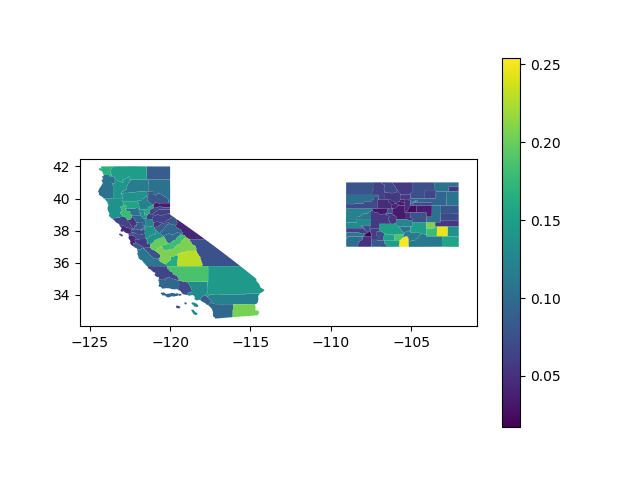

In [273]:
ca_population = county_gdf.merge(data, left_on = ('STATEFP','COUNTYFP') , right_on = ('state','county'))
ca_population['population_density'] = ca_population.B01001_001E / ca_population.ALAND
ca_population.plot(column = 'pct_under_poverty_line',legend = True)

In [279]:
tract_geodata = getCensusTracts(us.states.CA.fips)
tract_geodata.head()

/home/dan/anaconda3/envs/census-env/lib/python3.6/site-packages/cenpy/remote.py:172: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[cols] = df[cols].convert_objects(convert_numeric=convert_numeric)


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,B17026_008E,B17026_009E,B17026_010E,B17026_011E,B17026_012E,B17026_013E,state,county,tract,pct_under_poverty_line
0,06,037,137504,06037137504,1375.04,Census Tract 1375.04,G5020,S,3837562,0,...,0,0,52,22,25,447,06,037,137504,0.009042
1,06,037,138000,06037138000,1380,Census Tract 1380,G5020,S,4472196,0,...,0,10,62,71,128,866,06,037,138000,0.040284
2,06,037,139200,06037139200,1392,Census Tract 1392,G5020,S,1152031,0,...,17,39,254,166,164,626,06,037,139200,0.104536
3,06,067,002300,06067002300,23,Census Tract 23,G5020,S,1213095,0,...,0,0,58,53,145,578,06,067,002300,0.010601
4,06,067,002400,06067002400,24,Census Tract 24,G5020,S,3224718,0,...,0,0,25,39,43,1104,06,067,002400,0.013578


<IPython.core.display.Javascript object>


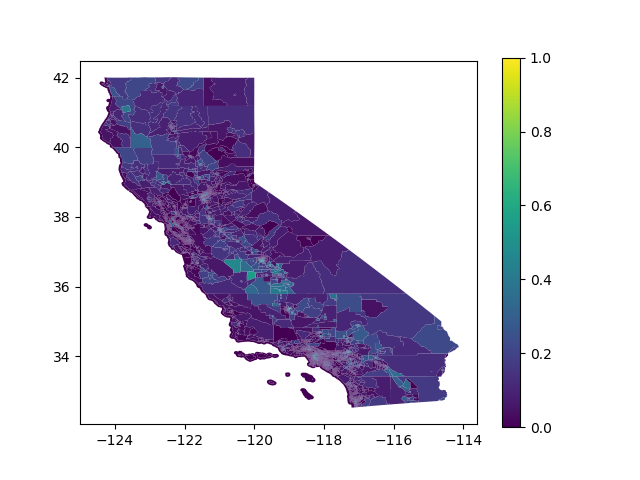

In [281]:

tract_geodata.plot(column = 'pct_under_poverty_line',legend = True)

In [346]:
my_location =  makeGeoDataFrame(34.0522,-118.2436)
my_location['buffer'] = my_location.buffer(.05)

my_buffer = geopandas.GeoDataFrame(my_location, geometry = 'buffer', crs = my_location.crs)

In [399]:
dummy_dataframe = pd.DataFrame(data ={'pct_under_poverty_line' : [0,2]})
foo  = geopandas.sjoin(tract_geodata,my_buffer)
#foo = foo.append(dummy_dataframe)

/home/dan/anaconda3/envs/census-env/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


<IPython.core.display.Javascript object>


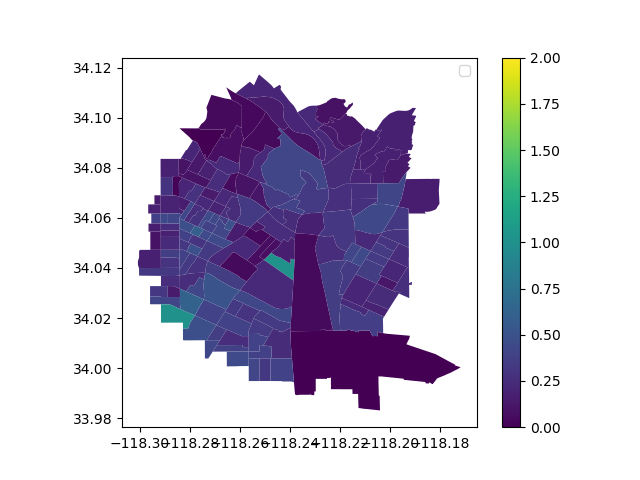

In [400]:

import matplotlib.pyplot as plt 
ax = foo.append(dummy_dataframe).plot('pct_under_poverty_line', legend = True)
#plt.colorbar(ax= ax, label = 'foo')
#plt.clim(0,1)
ax.legend((0,1))
plt.show(ax)


<IPython.core.display.Javascript object>


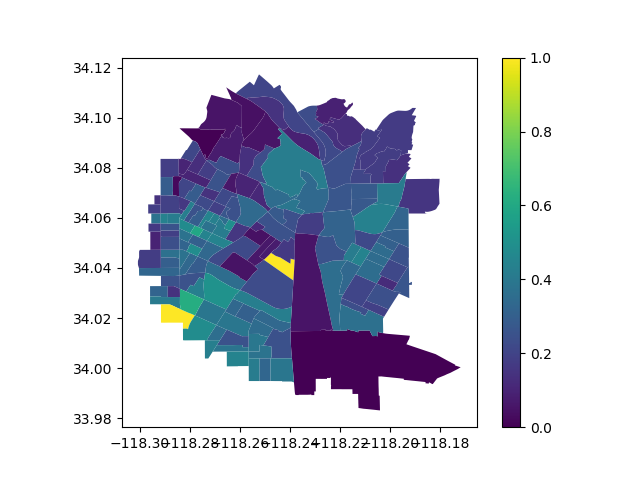

In [358]:
import matplotlib.pyplot as plt 
    fig, ax = plt.subplots()
ax.set_aspect('equal')
ax = geopandas.sjoin(tract_geodata,my_buffer).plot('pct_under_poverty_line',legend = True, ax = ax,)


In [359]:
plt.show()
